In [1]:
%reload_ext autoreload
%autoreload 2
%reload_ext lab_black

In [2]:
import logging
import string
import sys
import os

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from replay_trajectory_classification import (
    SortedSpikesClassifier,
    ClusterlessClassifier,
)

from src.figure_utilities import (
    PAGE_HEIGHT,
    ONE_COLUMN,
    TWO_COLUMN,
    save_figure,
    set_figure_defaults,
)
from src.parameters import STATE_COLORS, TRANSITION_TO_CATEGORY

set_figure_defaults()

In [3]:
FORMAT = "%(asctime)s %(message)s"
logging.basicConfig(level="INFO", format=FORMAT, datefmt="%d-%b-%y %H:%M:%S")

In [4]:
from glob import glob
import os
import pandas as pd
from src.parameters import PROCESSED_DATA_DIR, STATE_COLORS, STATE_ORDER
from src.figure_utilities import TWO_COLUMN, PAGE_HEIGHT, save_figure
import seaborn as sns
import matplotlib.pyplot as plt
from src.visualization import (
    plot_category_counts,
    plot_category_duration,
    plot_linear_position_markers,
)

from loren_frank_data_processing import make_tetrode_dataframe
from src.parameters import ANIMALS, STATE_ORDER, _BRAIN_AREAS

tetrode_info = make_tetrode_dataframe(ANIMALS)

data_type, dim = "clusterless", "1D"
n_unique_spiking = 2

file_paths = glob(
    os.path.join(PROCESSED_DATA_DIR, f"*_{data_type}_{dim}_replay_info_80.csv")
)
replay_info = pd.concat(
    [pd.read_csv(file_path) for file_path in file_paths], axis=0,
).set_index(["animal", "day", "epoch", "ripple_number"])
replay_info = replay_info.loc[
    replay_info.n_unique_spiking >= n_unique_spiking
].sort_index()

is_brain_areas = tetrode_info.area.astype(str).str.upper().isin(_BRAIN_AREAS)
n_tetrodes = (
    tetrode_info.loc[is_brain_areas]
    .groupby(["animal", "day", "epoch"])
    .tetrode_id.count()
    .rename("n_tetrodes")
)
replay_info = pd.merge(
    replay_info.reset_index(), pd.DataFrame(n_tetrodes).reset_index()
).set_index(["animal", "day", "epoch", "ripple_number"])

for state in STATE_ORDER:
    replay_info[f"{state}_pct_unique_spiking"] = (
        replay_info[f"{state}_n_unique_spiking"] / replay_info["n_tetrodes"]
    )
replay_info = replay_info.rename_axis(index={"animal": "Animal ID"})
replay_info.head()

start_time  \
Animal ID day epoch ripple_number                              
Cor       1   2     1              0 days 00:22:39.771534985   
                    2              0 days 00:23:00.114870107   
                    3              0 days 00:23:16.240204859   
                    4              0 days 00:23:21.014871945   
                    5              0 days 00:23:21.862205353   

                                                    end_time  duration  \
Animal ID day epoch ripple_number                                        
Cor       1   2     1              0 days 00:22:39.809534988  0.038000   
                    2              0 days 00:23:00.142870110  0.028000   
                    3              0 days 00:23:16.308871531  0.068667   
                    4              0 days 00:23:21.102871953  0.088000   
                    5              0 days 00:23:21.910205357  0.048000   

                                   Continuous_duration  Fragmented_duration  \
Animal ID day epoch ripple_number                                             
Cor       1   2     1                            0.000                  0.0   
                    2                            0.000                  0.0   
                    3                            0.000                  0.0   
                    4                            0.078                  0.0   
                    5                            0.000                  0.0   

                                   Fragmented-Continuous-Mix_duration  \
Animal ID day epoch ripple_number                                       
Cor       1   2     1                                           0.000   
                    2                                           0.000   
                    3                                           0.000   
                    4                                           0.004   
                    5                                           0.000   

                                   Hover_duration  \
Animal ID day epoch ripple_number                   
Cor       1   2     1                       0.000   
                    2                       0.026   
                    3                       0.030   
                    4                       0.000   
                    5                       0.000   

                                   Hover-Continuous-Mix_duration  Continuous  \
Animal ID day epoch ripple_number                                              
Cor       1   2     1                                      0.030       False   
                    2                                      0.000       False   
                    3                                      0.038       False   
                    4                                      0.000        True   
                    5                                      0.038       False   

                                   Fragmented  ...  left_well_position  \
Animal ID day epoch ripple_number              ...                       
Cor       1   2     1                   False  ...          301.995144   
                    2                   False  ...          301.995144   
                    3                   False  ...          301.995144   
                    4                   False  ...          301.995144   
                    5                   False  ...          301.995144   

                                   right_arm_start  right_well_position  \
Animal ID day epoch ripple_number                                         
Cor       1   2     1                    88.788252             183.8834   
                    2                    88.788252             183.8834   
                    3                    88.788252             183.8834   
                    4                    88.788252             183.8834   
                    5                    88.788252             183.8834   

                                   max

In [5]:
non_local_hcm = replay_info.loc[
    (
        replay_info.loc[:, "Hover-Continuous-Mix_replay_distance_from_actual_position"]
        > 30
    )
    & (replay_info.loc[:, "Hover-Continuous-Mix_duration"] > 0.150)
    & (replay_info.loc[:, "Hover-Continuous-Mix_spatial_coverage"] < 50)
    & (replay_info.loc[:, "Hover-Continuous-Mix_replay_speed"] / 100 < 1)
]
non_local_hcm.loc[
    :,
    [
        "Hover-Continuous-Mix_replay_distance_from_actual_position",
        "Hover-Continuous-Mix_duration",
        "Hover-Continuous-Mix_spatial_coverage",
        "Hover-Continuous-Mix_replay_speed",
    ],
]

Hover-Continuous-Mix_replay_distance_from_actual_position  \
Animal ID day epoch ripple_number                                                              
Cor       2   4     178                                                   110.525021           
bon       3   6     11                                                    164.436696           
                    54                                                    131.283771           
                    93                                                     44.625220           
          4   6     88                                                     34.607994           
...                                                                              ...           
gov       13  2     49                                                    161.104861           
                    64                                                    164.882778           
                    65                                                    163.881811           
              4     36                                                    159.503043           
                    119                                                    71.476304           

                                   Hover-Continuous-Mix_duration  \
Animal ID day epoch ripple_number                                  
Cor       2   4     178                                    0.182   
bon       3   6     11                                     0.164   
                    54                                     0.164   
                    93                                     0.216   
          4   6     88                                     0.152   
...                                                          ...   
gov       13  2     49                                     0.162   
                    64                                     0.158   
                    65                                     0.202   
              4     36                                     0.188   
                    119                                    0.178   

                                   Hover-Continuous-Mix_spatial_coverage  \
Animal ID day epoch ripple_number                                          
Cor       2   4     178                                        17.933796   
bon       3   6     11                                         11.679263   
                    54                                         23.358525   
                    93                                         17.518894   
          4   6     88                                         43.565253   
...                                                                  ...   
gov       13  2     49                                         20.561920   
                    64                                         20.561920   
                    65                                         17.624503   
              4     36                                         17.468044   
                    119                                        20.379385   

                                   Hover-Continuous-Mix_replay_speed  
Animal ID day epoch ripple_number                                     
Cor       2   4     178                                 4.786088e+01  
bon       3   6     11                                  4.773306e+01  
                    54                                  9.870573e+01  
                    93                                  7.231225e+01  
          4   6     88                                  3.512147e+01  
...                                                              ...  
gov       13  2     49                                  4.455079e+01  
                    64                                  0.000000e+00  
                    65                                  7.583822e+01  
              4     36                                  7.982880e+00  
                    119                                 6.58

In [6]:
from dask.distributed import LocalCluster, Client

cluster = LocalCluster(n_workers=28, threads_per_worker=1)
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:42417 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 28 Cores: 28 Memory: 1.62 TB


In [7]:
import copy

from src.load_data import load_data
from src.parameters import (
    ANIMALS,
    PROBABILITY_THRESHOLD,
    PROCESSED_DATA_DIR,
    SAMPLING_FREQUENCY,
    TRANSITION_TO_CATEGORY,
    continuous_transition_types,
    discrete_diag,
    model,
    model_kwargs,
    movement_var,
    place_bin_size,
    replay_speed,
)
from loren_frank_data_processing import (
    get_multiunit_dataframe,
    get_multiunit_dataframe2,
)
from loren_frank_data_processing.position import (
    make_track_graph,
    EDGE_ORDER,
    EDGE_SPACING,
)
from src.figure3 import plot_clusterless_1D_results, plot_1D_projected_to_2D
from src.visualization import make_classifier_movie
import xarray as xr


def plot_ripple_figure_1D(
    epoch_key, ripple_numbers, is_save_figure=True, cmap="bone_r", make_movie=True,
):
    if isinstance(ripple_numbers, int):
        ripple_numbers = [ripple_numbers]
    data_type, dim = "clusterless", "1D"
    animal, day, epoch = epoch_key
    data = load_data(epoch_key)

    multiunit_times = [
        get_multiunit_dataframe(tetrode_key, ANIMALS)
        for tetrode_key in data["tetrode_info"].index
    ]
    if multiunit_times[0] is None:
        multiunit_times = [
            get_multiunit_dataframe2(tetrode_key, ANIMALS)
            for tetrode_key in data["tetrode_info"].index
        ]

    # Fit
    is_training = data["position_info"].speed > 4
    position = data["position_info"].loc[:, "linear_position"]
    track_graph, center_well_id = make_track_graph(epoch_key, ANIMALS)

    model_name = os.path.join(
        PROCESSED_DATA_DIR, f"{animal}_{day:02}_{epoch:02}_{data_type}_{dim}_model.pkl"
    )
    classifier = ClusterlessClassifier.load_model(model_name)

    results = xr.open_dataset(
        os.path.join(PROCESSED_DATA_DIR, f"{animal}_{day:02d}_{epoch:02d}.nc"),
        group=f"/{data_type}/{dim}/classifier/ripples/",
    )

    for ripple_number in ripple_numbers:
        print(ripple_number)
        plot_clusterless_1D_results(
            multiunit_times,
            data,
            results.sel(ripple_number=ripple_number).dropna("time", how="all"),
            classifier,
            epoch_key,
            ripple_number,
            cmap=cmap,
            is_save_figure=is_save_figure,
        )
        plt.suptitle(f"{animal}, {day}, {epoch}, {ripple_number}")
        if make_movie:
            make_classifier_movie(classifier, results, ripple_number, data, epoch_key)

('Cor', 2, 4)


07-Oct-20 17:06:00 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Corriander/CorDIO02.mat
07-Oct-20 17:06:00 No DIO file found, using distance from well to segment trials
07-Oct-20 17:06:00 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Corriander/CorDIO02.mat
07-Oct-20 17:06:00 No DIO file found, inferring correct inbound/outbound from task rules
07-Oct-20 17:06:26 Finding ripple times...
07-Oct-20 17:09:09 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Corriander/CorDIO02.mat
07-Oct-20 17:09:09 No DIO file found, using distance from well to segment trials
07-Oct-20 17:09:10 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Corriander/CorDIO02.mat
07-Oct-20 17:09:10 No DIO file found, inferring correct inbound/outbound from task rules


178
('bon', 3, 6)


07-Oct-20 17:10:46 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO03.mat
07-Oct-20 17:10:46 No DIO file found, using distance from well to segment trials
07-Oct-20 17:10:47 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO03.mat
07-Oct-20 17:10:47 No DIO file found, inferring correct inbound/outbound from task rules
07-Oct-20 17:11:28 Finding ripple times...
07-Oct-20 17:14:23 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO03.mat
07-Oct-20 17:14:23 No DIO file found, using distance from well to segment trials
07-Oct-20 17:14:23 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO03.mat
07-Oct-20 17:14:23 No DIO file found, inferring correct inbound/outbound from task rules


11
54
93
('bon', 4, 6)


07-Oct-20 17:16:07 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO04.mat
07-Oct-20 17:16:07 No DIO file found, using distance from well to segment trials
07-Oct-20 17:16:08 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO04.mat
07-Oct-20 17:16:08 No DIO file found, inferring correct inbound/outbound from task rules
07-Oct-20 17:16:52 Finding ripple times...
07-Oct-20 17:19:49 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO04.mat
07-Oct-20 17:19:49 No DIO file found, using distance from well to segment trials
07-Oct-20 17:19:49 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO04.mat
07-Oct-20 17:19:49 No DIO file found, inferring correct inbound/outbound from task rules


88
('bon', 6, 6)


07-Oct-20 17:21:36 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO06.mat
07-Oct-20 17:21:36 No DIO file found, using distance from well to segment trials
07-Oct-20 17:21:37 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO06.mat
07-Oct-20 17:21:37 No DIO file found, inferring correct inbound/outbound from task rules
07-Oct-20 17:22:21 Finding ripple times...
07-Oct-20 17:25:17 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO06.mat
07-Oct-20 17:25:17 No DIO file found, using distance from well to segment trials
07-Oct-20 17:25:19 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO06.mat
07-Oct-20 17:25:19 No DIO file found, inferring correct inbound/outbound from task rules


93
('bon', 7, 6)


07-Oct-20 17:27:07 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO07.mat
07-Oct-20 17:27:07 No DIO file found, using distance from well to segment trials
07-Oct-20 17:27:08 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO07.mat
07-Oct-20 17:27:08 No DIO file found, inferring correct inbound/outbound from task rules
07-Oct-20 17:27:53 Finding ripple times...
07-Oct-20 17:30:49 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO07.mat
07-Oct-20 17:30:49 No DIO file found, using distance from well to segment trials
07-Oct-20 17:30:51 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO07.mat
07-Oct-20 17:30:51 No DIO file found, inferring correct inbound/outbound from task rules


76
('bon', 8, 2)


07-Oct-20 17:32:38 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO08.mat
07-Oct-20 17:32:38 No DIO file found, using distance from well to segment trials
07-Oct-20 17:32:38 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO08.mat
07-Oct-20 17:32:38 No DIO file found, inferring correct inbound/outbound from task rules
07-Oct-20 17:33:21 Finding ripple times...
07-Oct-20 17:36:21 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO08.mat
07-Oct-20 17:36:21 No DIO file found, using distance from well to segment trials
07-Oct-20 17:36:22 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO08.mat
07-Oct-20 17:36:22 No DIO file found, inferring correct inbound/outbound from task rules


57
('bon', 8, 4)


07-Oct-20 17:38:13 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO08.mat
07-Oct-20 17:38:13 No DIO file found, using distance from well to segment trials
07-Oct-20 17:38:14 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO08.mat
07-Oct-20 17:38:14 No DIO file found, inferring correct inbound/outbound from task rules
07-Oct-20 17:38:56 Finding ripple times...
07-Oct-20 17:41:57 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO08.mat
07-Oct-20 17:41:57 No DIO file found, using distance from well to segment trials
07-Oct-20 17:41:59 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO08.mat
07-Oct-20 17:41:59 No DIO file found, inferring correct inbound/outbound from task rules


238
('bon', 9, 2)


07-Oct-20 17:43:51 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO09.mat
07-Oct-20 17:43:51 No DIO file found, using distance from well to segment trials
07-Oct-20 17:43:52 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO09.mat
07-Oct-20 17:43:52 No DIO file found, inferring correct inbound/outbound from task rules
07-Oct-20 17:44:41 Finding ripple times...
07-Oct-20 17:47:45 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO09.mat
07-Oct-20 17:47:45 No DIO file found, using distance from well to segment trials
07-Oct-20 17:47:47 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO09.mat
07-Oct-20 17:47:47 No DIO file found, inferring correct inbound/outbound from task rules


218
('bon', 9, 4)


07-Oct-20 17:49:37 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO09.mat
07-Oct-20 17:49:37 No DIO file found, using distance from well to segment trials
07-Oct-20 17:49:38 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO09.mat
07-Oct-20 17:49:38 No DIO file found, inferring correct inbound/outbound from task rules
07-Oct-20 17:50:25 Finding ripple times...
07-Oct-20 17:53:28 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO09.mat
07-Oct-20 17:53:28 No DIO file found, using distance from well to segment trials
07-Oct-20 17:53:30 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO09.mat
07-Oct-20 17:53:30 No DIO file found, inferring correct inbound/outbound from task rules


18
46
('bon', 9, 6)


07-Oct-20 17:55:17 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO09.mat
07-Oct-20 17:55:17 No DIO file found, using distance from well to segment trials
07-Oct-20 17:55:18 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO09.mat
07-Oct-20 17:55:18 No DIO file found, inferring correct inbound/outbound from task rules
07-Oct-20 17:56:03 Finding ripple times...
07-Oct-20 17:59:02 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO09.mat
07-Oct-20 17:59:02 No DIO file found, using distance from well to segment trials
07-Oct-20 17:59:03 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO09.mat
07-Oct-20 17:59:03 No DIO file found, inferring correct inbound/outbound from task rules


50
('bon', 10, 2)


07-Oct-20 18:00:51 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO10.mat
07-Oct-20 18:00:51 No DIO file found, using distance from well to segment trials
07-Oct-20 18:00:52 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO10.mat
07-Oct-20 18:00:52 No DIO file found, inferring correct inbound/outbound from task rules
07-Oct-20 18:01:38 Finding ripple times...
07-Oct-20 18:04:41 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO10.mat
07-Oct-20 18:04:41 No DIO file found, using distance from well to segment trials
07-Oct-20 18:04:42 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO10.mat
07-Oct-20 18:04:42 No DIO file found, inferring correct inbound/outbound from task rules


81
222
('bon', 10, 4)


07-Oct-20 18:06:34 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO10.mat
07-Oct-20 18:06:34 No DIO file found, using distance from well to segment trials
07-Oct-20 18:06:35 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO10.mat
07-Oct-20 18:06:35 No DIO file found, inferring correct inbound/outbound from task rules
07-Oct-20 18:07:21 Finding ripple times...
07-Oct-20 18:10:22 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO10.mat
07-Oct-20 18:10:22 No DIO file found, using distance from well to segment trials
07-Oct-20 18:10:24 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO10.mat
07-Oct-20 18:10:24 No DIO file found, inferring correct inbound/outbound from task rules


186
194
('bon', 10, 6)


07-Oct-20 18:12:15 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO10.mat
07-Oct-20 18:12:15 No DIO file found, using distance from well to segment trials
07-Oct-20 18:12:16 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO10.mat
07-Oct-20 18:12:16 No DIO file found, inferring correct inbound/outbound from task rules
07-Oct-20 18:13:04 Finding ripple times...
07-Oct-20 18:16:02 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO10.mat
07-Oct-20 18:16:02 No DIO file found, using distance from well to segment trials
07-Oct-20 18:16:03 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO10.mat
07-Oct-20 18:16:03 No DIO file found, inferring correct inbound/outbound from task rules


11
39
130
134
('cha', 4, 2)


07-Oct-20 18:17:55 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Chapati/chaDIO04.mat
07-Oct-20 18:17:55 No DIO file found, using distance from well to segment trials
07-Oct-20 18:17:55 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Chapati/chaDIO04.mat
07-Oct-20 18:17:55 No DIO file found, inferring correct inbound/outbound from task rules
07-Oct-20 18:18:18 Finding ripple times...
07-Oct-20 18:21:14 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Chapati/chaDIO04.mat
07-Oct-20 18:21:14 No DIO file found, using distance from well to segment trials
07-Oct-20 18:21:15 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Chapati/chaDIO04.mat
07-Oct-20 18:21:15 No DIO file found, inferring correct inbound/outbound from task rules


33
('cha', 4, 4)


07-Oct-20 18:22:55 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Chapati/chaDIO04.mat
07-Oct-20 18:22:55 No DIO file found, using distance from well to segment trials
07-Oct-20 18:22:56 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Chapati/chaDIO04.mat
07-Oct-20 18:22:56 No DIO file found, inferring correct inbound/outbound from task rules
07-Oct-20 18:23:18 Finding ripple times...
07-Oct-20 18:26:14 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Chapati/chaDIO04.mat
07-Oct-20 18:26:14 No DIO file found, using distance from well to segment trials
07-Oct-20 18:26:15 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Chapati/chaDIO04.mat
07-Oct-20 18:26:15 No DIO file found, inferring correct inbound/outbound from task rules


16
51
165
('cha', 8, 2)


07-Oct-20 18:27:59 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Chapati/chaDIO08.mat
07-Oct-20 18:27:59 No DIO file found, using distance from well to segment trials
07-Oct-20 18:27:59 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Chapati/chaDIO08.mat
07-Oct-20 18:27:59 No DIO file found, inferring correct inbound/outbound from task rules
07-Oct-20 18:28:21 Finding ripple times...
07-Oct-20 18:31:22 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Chapati/chaDIO08.mat
07-Oct-20 18:31:22 No DIO file found, using distance from well to segment trials
07-Oct-20 18:31:23 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Chapati/chaDIO08.mat
07-Oct-20 18:31:23 No DIO file found, inferring correct inbound/outbound from task rules


103
('cha', 8, 4)


07-Oct-20 18:33:05 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Chapati/chaDIO08.mat
07-Oct-20 18:33:05 No DIO file found, using distance from well to segment trials
07-Oct-20 18:33:05 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Chapati/chaDIO08.mat
07-Oct-20 18:33:05 No DIO file found, inferring correct inbound/outbound from task rules
07-Oct-20 18:33:27 Finding ripple times...
07-Oct-20 18:36:20 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Chapati/chaDIO08.mat
07-Oct-20 18:36:20 No DIO file found, using distance from well to segment trials
07-Oct-20 18:36:21 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Chapati/chaDIO08.mat
07-Oct-20 18:36:21 No DIO file found, inferring correct inbound/outbound from task rules


10
('dav', 3, 4)


07-Oct-20 18:38:01 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Dave/davDIO03.mat
07-Oct-20 18:38:01 No DIO file found, using distance from well to segment trials
07-Oct-20 18:38:02 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Dave/davDIO03.mat
07-Oct-20 18:38:02 No DIO file found, inferring correct inbound/outbound from task rules
07-Oct-20 18:38:24 Finding ripple times...
07-Oct-20 18:41:22 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Dave/davDIO03.mat
07-Oct-20 18:41:22 No DIO file found, using distance from well to segment trials
07-Oct-20 18:41:23 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Dave/davDIO03.mat
07-Oct-20 18:41:23 No DIO file found, inferring correct inbound/outbound from task rules


102
105
('dav', 3, 6)


07-Oct-20 18:43:03 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Dave/davDIO03.mat
07-Oct-20 18:43:03 No DIO file found, using distance from well to segment trials
07-Oct-20 18:43:03 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Dave/davDIO03.mat
07-Oct-20 18:43:03 No DIO file found, inferring correct inbound/outbound from task rules
07-Oct-20 18:43:25 Finding ripple times...
07-Oct-20 18:46:21 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Dave/davDIO03.mat
07-Oct-20 18:46:21 No DIO file found, using distance from well to segment trials
07-Oct-20 18:46:22 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Dave/davDIO03.mat
07-Oct-20 18:46:22 No DIO file found, inferring correct inbound/outbound from task rules


15
('dav', 5, 3)


07-Oct-20 18:48:03 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Dave/davDIO05.mat
07-Oct-20 18:48:03 No DIO file found, using distance from well to segment trials
07-Oct-20 18:48:04 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Dave/davDIO05.mat
07-Oct-20 18:48:04 No DIO file found, inferring correct inbound/outbound from task rules
07-Oct-20 18:48:29 Finding ripple times...
07-Oct-20 18:51:26 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Dave/davDIO05.mat
07-Oct-20 18:51:26 No DIO file found, using distance from well to segment trials
07-Oct-20 18:51:27 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Dave/davDIO05.mat
07-Oct-20 18:51:27 No DIO file found, inferring correct inbound/outbound from task rules


34
('dav', 6, 2)


07-Oct-20 18:53:06 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Dave/davDIO06.mat
07-Oct-20 18:53:06 No DIO file found, using distance from well to segment trials
07-Oct-20 18:53:07 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Dave/davDIO06.mat
07-Oct-20 18:53:07 No DIO file found, inferring correct inbound/outbound from task rules
07-Oct-20 18:53:32 Finding ripple times...
07-Oct-20 18:56:30 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Dave/davDIO06.mat
07-Oct-20 18:56:30 No DIO file found, using distance from well to segment trials
07-Oct-20 18:56:31 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Dave/davDIO06.mat
07-Oct-20 18:56:31 No DIO file found, inferring correct inbound/outbound from task rules


19
29
74
('dav', 6, 4)


07-Oct-20 18:58:15 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Dave/davDIO06.mat
07-Oct-20 18:58:15 No DIO file found, using distance from well to segment trials
07-Oct-20 18:58:15 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Dave/davDIO06.mat
07-Oct-20 18:58:15 No DIO file found, inferring correct inbound/outbound from task rules
07-Oct-20 18:58:41 Finding ripple times...
07-Oct-20 19:01:39 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Dave/davDIO06.mat
07-Oct-20 19:01:39 No DIO file found, using distance from well to segment trials
07-Oct-20 19:01:40 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Dave/davDIO06.mat
07-Oct-20 19:01:40 No DIO file found, inferring correct inbound/outbound from task rules


28
104
('dav', 6, 6)


07-Oct-20 19:03:22 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Dave/davDIO06.mat
07-Oct-20 19:03:22 No DIO file found, using distance from well to segment trials
07-Oct-20 19:03:22 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Dave/davDIO06.mat
07-Oct-20 19:03:22 No DIO file found, inferring correct inbound/outbound from task rules
07-Oct-20 19:03:45 Finding ripple times...
07-Oct-20 19:06:43 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Dave/davDIO06.mat
07-Oct-20 19:06:43 No DIO file found, using distance from well to segment trials
07-Oct-20 19:06:45 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Dave/davDIO06.mat
07-Oct-20 19:06:45 No DIO file found, inferring correct inbound/outbound from task rules


108
('dav', 7, 2)


07-Oct-20 19:08:08 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Dave/davDIO07.mat
07-Oct-20 19:08:08 No DIO file found, using distance from well to segment trials
07-Oct-20 19:08:08 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Dave/davDIO07.mat
07-Oct-20 19:08:08 No DIO file found, inferring correct inbound/outbound from task rules
07-Oct-20 19:08:29 Finding ripple times...
07-Oct-20 19:10:36 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Dave/davDIO07.mat
07-Oct-20 19:10:36 No DIO file found, using distance from well to segment trials
07-Oct-20 19:10:36 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Dave/davDIO07.mat
07-Oct-20 19:10:36 No DIO file found, inferring correct inbound/outbound from task rules


11
28
36
('dav', 7, 3)


07-Oct-20 19:11:45 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Dave/davDIO07.mat
07-Oct-20 19:11:45 No DIO file found, using distance from well to segment trials
07-Oct-20 19:11:45 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Dave/davDIO07.mat
07-Oct-20 19:11:45 No DIO file found, inferring correct inbound/outbound from task rules
07-Oct-20 19:12:07 Finding ripple times...
07-Oct-20 19:13:49 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Dave/davDIO07.mat
07-Oct-20 19:13:49 No DIO file found, using distance from well to segment trials
07-Oct-20 19:13:49 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Dave/davDIO07.mat
07-Oct-20 19:13:49 No DIO file found, inferring correct inbound/outbound from task rules


7
20
28
42
('dav', 7, 5)


07-Oct-20 19:15:23 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Dave/davDIO07.mat
07-Oct-20 19:15:23 No DIO file found, using distance from well to segment trials
07-Oct-20 19:15:24 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Dave/davDIO07.mat
07-Oct-20 19:15:24 No DIO file found, inferring correct inbound/outbound from task rules
07-Oct-20 19:15:47 Finding ripple times...
07-Oct-20 19:18:43 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Dave/davDIO07.mat
07-Oct-20 19:18:43 No DIO file found, using distance from well to segment trials
07-Oct-20 19:18:44 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Dave/davDIO07.mat
07-Oct-20 19:18:44 No DIO file found, inferring correct inbound/outbound from task rules


6
15
24
73
('dav', 7, 7)


07-Oct-20 19:20:32 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Dave/davDIO07.mat
07-Oct-20 19:20:32 No DIO file found, using distance from well to segment trials
07-Oct-20 19:20:33 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Dave/davDIO07.mat
07-Oct-20 19:20:33 No DIO file found, inferring correct inbound/outbound from task rules
07-Oct-20 19:20:56 Finding ripple times...
07-Oct-20 19:24:13 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Dave/davDIO07.mat
07-Oct-20 19:24:13 No DIO file found, using distance from well to segment trials
07-Oct-20 19:24:14 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Dave/davDIO07.mat
07-Oct-20 19:24:14 No DIO file found, inferring correct inbound/outbound from task rules


16
46
52
67
93
('dav', 7, 9)


07-Oct-20 19:25:58 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Dave/davDIO07.mat
07-Oct-20 19:25:58 No DIO file found, using distance from well to segment trials
07-Oct-20 19:25:58 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Dave/davDIO07.mat
07-Oct-20 19:25:58 No DIO file found, inferring correct inbound/outbound from task rules
07-Oct-20 19:26:21 Finding ripple times...
07-Oct-20 19:29:18 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Dave/davDIO07.mat
07-Oct-20 19:29:18 No DIO file found, using distance from well to segment trials
07-Oct-20 19:29:18 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Dave/davDIO07.mat
07-Oct-20 19:29:18 No DIO file found, inferring correct inbound/outbound from task rules


62
('dud', 2, 2)


07-Oct-20 19:31:33 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Dudley/dudDIO02.mat
07-Oct-20 19:31:33 No DIO file found, using distance from well to segment trials
07-Oct-20 19:31:34 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Dudley/dudDIO02.mat
07-Oct-20 19:31:34 No DIO file found, inferring correct inbound/outbound from task rules
07-Oct-20 19:31:57 Finding ripple times...
07-Oct-20 19:36:12 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Dudley/dudDIO02.mat
07-Oct-20 19:36:12 No DIO file found, using distance from well to segment trials
07-Oct-20 19:36:14 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Dudley/dudDIO02.mat
07-Oct-20 19:36:14 No DIO file found, inferring correct inbound/outbound from task rules


186
('egy', 5, 2)


07-Oct-20 19:38:17 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Egypt/egyDIO05.mat
07-Oct-20 19:38:17 No DIO file found, using distance from well to segment trials
07-Oct-20 19:38:18 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Egypt/egyDIO05.mat
07-Oct-20 19:38:18 No DIO file found, inferring correct inbound/outbound from task rules
07-Oct-20 19:38:49 Finding ripple times...
07-Oct-20 19:42:09 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Egypt/egyDIO05.mat
07-Oct-20 19:42:09 No DIO file found, using distance from well to segment trials
07-Oct-20 19:42:11 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Egypt/egyDIO05.mat
07-Oct-20 19:42:11 No DIO file found, inferring correct inbound/outbound from task rules


60
('egy', 5, 4)


07-Oct-20 19:43:59 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Egypt/egyDIO05.mat
07-Oct-20 19:43:59 No DIO file found, using distance from well to segment trials
07-Oct-20 19:43:59 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Egypt/egyDIO05.mat
07-Oct-20 19:43:59 No DIO file found, inferring correct inbound/outbound from task rules
07-Oct-20 19:44:31 Finding ripple times...
07-Oct-20 19:47:29 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Egypt/egyDIO05.mat
07-Oct-20 19:47:29 No DIO file found, using distance from well to segment trials
07-Oct-20 19:47:30 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Egypt/egyDIO05.mat
07-Oct-20 19:47:30 No DIO file found, inferring correct inbound/outbound from task rules


107
('egy', 7, 2)


07-Oct-20 19:49:15 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Egypt/egyDIO07.mat
07-Oct-20 19:49:15 No DIO file found, using distance from well to segment trials
07-Oct-20 19:49:15 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Egypt/egyDIO07.mat
07-Oct-20 19:49:15 No DIO file found, inferring correct inbound/outbound from task rules
07-Oct-20 19:49:46 Finding ripple times...
07-Oct-20 19:52:43 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Egypt/egyDIO07.mat
07-Oct-20 19:52:43 No DIO file found, using distance from well to segment trials
07-Oct-20 19:52:44 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Egypt/egyDIO07.mat
07-Oct-20 19:52:44 No DIO file found, inferring correct inbound/outbound from task rules


64
197
('egy', 7, 6)


07-Oct-20 19:54:28 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Egypt/egyDIO07.mat
07-Oct-20 19:54:28 No DIO file found, using distance from well to segment trials
07-Oct-20 19:54:28 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Egypt/egyDIO07.mat
07-Oct-20 19:54:28 No DIO file found, inferring correct inbound/outbound from task rules
07-Oct-20 19:54:59 Finding ripple times...
07-Oct-20 19:57:55 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Egypt/egyDIO07.mat
07-Oct-20 19:57:55 No DIO file found, using distance from well to segment trials
07-Oct-20 19:57:56 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Egypt/egyDIO07.mat
07-Oct-20 19:57:56 No DIO file found, inferring correct inbound/outbound from task rules


162
('egy', 8, 4)


07-Oct-20 19:59:43 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Egypt/egyDIO08.mat
07-Oct-20 19:59:43 No DIO file found, using distance from well to segment trials
07-Oct-20 19:59:43 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Egypt/egyDIO08.mat
07-Oct-20 19:59:43 No DIO file found, inferring correct inbound/outbound from task rules
07-Oct-20 20:00:15 Finding ripple times...
07-Oct-20 20:03:14 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Egypt/egyDIO08.mat
07-Oct-20 20:03:14 No DIO file found, using distance from well to segment trials
07-Oct-20 20:03:15 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Egypt/egyDIO08.mat
07-Oct-20 20:03:15 No DIO file found, inferring correct inbound/outbound from task rules


55
('egy', 8, 6)


07-Oct-20 20:05:03 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Egypt/egyDIO08.mat
07-Oct-20 20:05:03 No DIO file found, using distance from well to segment trials
07-Oct-20 20:05:03 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Egypt/egyDIO08.mat
07-Oct-20 20:05:03 No DIO file found, inferring correct inbound/outbound from task rules
07-Oct-20 20:05:34 Finding ripple times...
07-Oct-20 20:08:34 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Egypt/egyDIO08.mat
07-Oct-20 20:08:34 No DIO file found, using distance from well to segment trials
07-Oct-20 20:08:35 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Egypt/egyDIO08.mat
07-Oct-20 20:08:35 No DIO file found, inferring correct inbound/outbound from task rules


89
107
('egy', 9, 2)


07-Oct-20 20:10:22 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Egypt/egyDIO09.mat
07-Oct-20 20:10:22 No DIO file found, using distance from well to segment trials
07-Oct-20 20:10:23 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Egypt/egyDIO09.mat
07-Oct-20 20:10:23 No DIO file found, inferring correct inbound/outbound from task rules
07-Oct-20 20:10:56 Finding ripple times...
07-Oct-20 20:13:55 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Egypt/egyDIO09.mat
07-Oct-20 20:13:56 No DIO file found, using distance from well to segment trials
07-Oct-20 20:13:56 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Egypt/egyDIO09.mat
07-Oct-20 20:13:56 No DIO file found, inferring correct inbound/outbound from task rules


49
85
('egy', 10, 6)


07-Oct-20 20:15:44 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Egypt/egyDIO10.mat
07-Oct-20 20:15:44 No DIO file found, using distance from well to segment trials
07-Oct-20 20:15:44 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Egypt/egyDIO10.mat
07-Oct-20 20:15:44 No DIO file found, inferring correct inbound/outbound from task rules
07-Oct-20 20:16:15 Finding ripple times...
07-Oct-20 20:19:14 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Egypt/egyDIO10.mat
07-Oct-20 20:19:14 No DIO file found, using distance from well to segment trials
07-Oct-20 20:19:15 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Egypt/egyDIO10.mat
07-Oct-20 20:19:15 No DIO file found, inferring correct inbound/outbound from task rules


95
111
142
('egy', 11, 6)


07-Oct-20 20:21:03 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Egypt/egyDIO11.mat
07-Oct-20 20:21:03 No DIO file found, using distance from well to segment trials
07-Oct-20 20:21:03 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Egypt/egyDIO11.mat
07-Oct-20 20:21:03 No DIO file found, inferring correct inbound/outbound from task rules
07-Oct-20 20:21:36 Finding ripple times...
07-Oct-20 20:24:39 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Egypt/egyDIO11.mat
07-Oct-20 20:24:39 No DIO file found, using distance from well to segment trials
07-Oct-20 20:24:40 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Egypt/egyDIO11.mat
07-Oct-20 20:24:40 No DIO file found, inferring correct inbound/outbound from task rules


29
('fra', 4, 6)


07-Oct-20 20:26:22 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Frank/fraDIO04.mat
07-Oct-20 20:26:22 No DIO file found, using distance from well to segment trials
07-Oct-20 20:26:23 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Frank/fraDIO04.mat
07-Oct-20 20:26:23 No DIO file found, inferring correct inbound/outbound from task rules
07-Oct-20 20:26:58 Finding ripple times...
07-Oct-20 20:29:58 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Frank/fraDIO04.mat
07-Oct-20 20:29:58 No DIO file found, using distance from well to segment trials
07-Oct-20 20:29:59 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Frank/fraDIO04.mat
07-Oct-20 20:29:59 No DIO file found, inferring correct inbound/outbound from task rules


150
('fra', 6, 2)


07-Oct-20 20:31:43 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Frank/fraDIO06.mat
07-Oct-20 20:31:43 No DIO file found, using distance from well to segment trials
07-Oct-20 20:31:44 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Frank/fraDIO06.mat
07-Oct-20 20:31:44 No DIO file found, inferring correct inbound/outbound from task rules
07-Oct-20 20:32:23 Finding ripple times...
07-Oct-20 20:35:23 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Frank/fraDIO06.mat
07-Oct-20 20:35:23 No DIO file found, using distance from well to segment trials
07-Oct-20 20:35:24 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Frank/fraDIO06.mat
07-Oct-20 20:35:24 No DIO file found, inferring correct inbound/outbound from task rules


17
('fra', 6, 4)


07-Oct-20 20:37:08 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Frank/fraDIO06.mat
07-Oct-20 20:37:08 No DIO file found, using distance from well to segment trials
07-Oct-20 20:37:09 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Frank/fraDIO06.mat
07-Oct-20 20:37:09 No DIO file found, inferring correct inbound/outbound from task rules
07-Oct-20 20:37:49 Finding ripple times...
07-Oct-20 20:40:46 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Frank/fraDIO06.mat
07-Oct-20 20:40:46 No DIO file found, using distance from well to segment trials
07-Oct-20 20:40:48 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Frank/fraDIO06.mat
07-Oct-20 20:40:48 No DIO file found, inferring correct inbound/outbound from task rules


233
('fra', 7, 4)


07-Oct-20 20:42:35 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Frank/fraDIO07.mat
07-Oct-20 20:42:35 No DIO file found, using distance from well to segment trials
07-Oct-20 20:42:36 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Frank/fraDIO07.mat
07-Oct-20 20:42:36 No DIO file found, inferring correct inbound/outbound from task rules
07-Oct-20 20:43:15 Finding ripple times...
07-Oct-20 20:46:17 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Frank/fraDIO07.mat
07-Oct-20 20:46:17 No DIO file found, using distance from well to segment trials
07-Oct-20 20:46:18 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Frank/fraDIO07.mat
07-Oct-20 20:46:18 No DIO file found, inferring correct inbound/outbound from task rules


189
('fra', 9, 2)


07-Oct-20 20:48:05 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Frank/fraDIO09.mat
07-Oct-20 20:48:05 No DIO file found, using distance from well to segment trials
07-Oct-20 20:48:06 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Frank/fraDIO09.mat
07-Oct-20 20:48:06 No DIO file found, inferring correct inbound/outbound from task rules
07-Oct-20 20:48:45 Finding ripple times...
07-Oct-20 20:51:47 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Frank/fraDIO09.mat
07-Oct-20 20:51:47 No DIO file found, using distance from well to segment trials
07-Oct-20 20:51:50 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Frank/fraDIO09.mat
07-Oct-20 20:51:50 No DIO file found, inferring correct inbound/outbound from task rules


91
94
('fra', 9, 4)


07-Oct-20 20:53:37 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Frank/fraDIO09.mat
07-Oct-20 20:53:37 No DIO file found, using distance from well to segment trials
07-Oct-20 20:53:38 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Frank/fraDIO09.mat
07-Oct-20 20:53:38 No DIO file found, inferring correct inbound/outbound from task rules
07-Oct-20 20:54:16 Finding ripple times...
07-Oct-20 20:57:23 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Frank/fraDIO09.mat
07-Oct-20 20:57:23 No DIO file found, using distance from well to segment trials
07-Oct-20 20:57:24 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Frank/fraDIO09.mat
07-Oct-20 20:57:24 No DIO file found, inferring correct inbound/outbound from task rules


54
68
157
174
('fra', 10, 4)


07-Oct-20 20:59:14 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Frank/fraDIO10.mat
07-Oct-20 20:59:14 No DIO file found, using distance from well to segment trials
07-Oct-20 20:59:16 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Frank/fraDIO10.mat
07-Oct-20 20:59:16 No DIO file found, inferring correct inbound/outbound from task rules
07-Oct-20 20:59:53 Finding ripple times...
07-Oct-20 21:03:02 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Frank/fraDIO10.mat
07-Oct-20 21:03:02 No DIO file found, using distance from well to segment trials
07-Oct-20 21:03:05 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Frank/fraDIO10.mat
07-Oct-20 21:03:05 No DIO file found, inferring correct inbound/outbound from task rules


211
('fra', 12, 2)


07-Oct-20 21:04:54 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Frank/fraDIO12.mat
07-Oct-20 21:04:54 No DIO file found, using distance from well to segment trials
07-Oct-20 21:04:54 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Frank/fraDIO12.mat
07-Oct-20 21:04:54 No DIO file found, inferring correct inbound/outbound from task rules
07-Oct-20 21:05:29 Finding ripple times...
07-Oct-20 21:08:37 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Frank/fraDIO12.mat
07-Oct-20 21:08:37 No DIO file found, using distance from well to segment trials
07-Oct-20 21:08:38 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Frank/fraDIO12.mat
07-Oct-20 21:08:38 No DIO file found, inferring correct inbound/outbound from task rules


58
145
('fra', 12, 6)


07-Oct-20 21:10:19 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Frank/fraDIO12.mat
07-Oct-20 21:10:19 No DIO file found, using distance from well to segment trials
07-Oct-20 21:10:20 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Frank/fraDIO12.mat
07-Oct-20 21:10:20 No DIO file found, inferring correct inbound/outbound from task rules
07-Oct-20 21:10:55 Finding ripple times...
07-Oct-20 21:13:56 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Frank/fraDIO12.mat
07-Oct-20 21:13:56 No DIO file found, using distance from well to segment trials
07-Oct-20 21:13:57 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Frank/fraDIO12.mat
07-Oct-20 21:13:57 No DIO file found, inferring correct inbound/outbound from task rules


115
('gov', 6, 4)


07-Oct-20 21:15:38 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Government/govDIO06.mat
07-Oct-20 21:15:38 No DIO file found, using distance from well to segment trials
07-Oct-20 21:15:38 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Government/govDIO06.mat
07-Oct-20 21:15:38 No DIO file found, inferring correct inbound/outbound from task rules
07-Oct-20 21:16:16 Finding ripple times...
07-Oct-20 21:19:12 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Government/govDIO06.mat
07-Oct-20 21:19:12 No DIO file found, using distance from well to segment trials
07-Oct-20 21:19:13 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Government/govDIO06.mat
07-Oct-20 21:19:13 No DIO file found, inferring correct inbound/outbound from task rules


79
('gov', 6, 6)


07-Oct-20 21:21:07 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Government/govDIO06.mat
07-Oct-20 21:21:07 No DIO file found, using distance from well to segment trials
07-Oct-20 21:21:07 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Government/govDIO06.mat
07-Oct-20 21:21:07 No DIO file found, inferring correct inbound/outbound from task rules
07-Oct-20 21:21:44 Finding ripple times...
07-Oct-20 21:24:41 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Government/govDIO06.mat
07-Oct-20 21:24:41 No DIO file found, using distance from well to segment trials
07-Oct-20 21:24:42 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Government/govDIO06.mat
07-Oct-20 21:24:42 No DIO file found, inferring correct inbound/outbound from task rules


48
('gov', 7, 6)


07-Oct-20 21:26:37 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Government/govDIO07.mat
07-Oct-20 21:26:37 No DIO file found, using distance from well to segment trials
07-Oct-20 21:26:37 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Government/govDIO07.mat
07-Oct-20 21:26:37 No DIO file found, inferring correct inbound/outbound from task rules
07-Oct-20 21:27:17 Finding ripple times...
07-Oct-20 21:30:15 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Government/govDIO07.mat
07-Oct-20 21:30:15 No DIO file found, using distance from well to segment trials
07-Oct-20 21:30:16 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Government/govDIO07.mat
07-Oct-20 21:30:16 No DIO file found, inferring correct inbound/outbound from task rules


27
('gov', 8, 2)


07-Oct-20 21:32:16 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Government/govDIO08.mat
07-Oct-20 21:32:16 No DIO file found, using distance from well to segment trials
07-Oct-20 21:32:16 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Government/govDIO08.mat
07-Oct-20 21:32:16 No DIO file found, inferring correct inbound/outbound from task rules
07-Oct-20 21:32:59 Finding ripple times...
07-Oct-20 21:36:12 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Government/govDIO08.mat
07-Oct-20 21:36:12 No DIO file found, using distance from well to segment trials
07-Oct-20 21:36:13 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Government/govDIO08.mat
07-Oct-20 21:36:13 No DIO file found, inferring correct inbound/outbound from task rules


8
29
120
('gov', 8, 4)


07-Oct-20 21:38:10 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Government/govDIO08.mat
07-Oct-20 21:38:10 No DIO file found, using distance from well to segment trials
07-Oct-20 21:38:10 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Government/govDIO08.mat
07-Oct-20 21:38:10 No DIO file found, inferring correct inbound/outbound from task rules
07-Oct-20 21:38:50 Finding ripple times...
07-Oct-20 21:41:53 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Government/govDIO08.mat
07-Oct-20 21:41:53 No DIO file found, using distance from well to segment trials
07-Oct-20 21:41:54 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Government/govDIO08.mat
07-Oct-20 21:41:54 No DIO file found, inferring correct inbound/outbound from task rules


11
96
('gov', 8, 6)


07-Oct-20 21:43:47 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Government/govDIO08.mat
07-Oct-20 21:43:47 No DIO file found, using distance from well to segment trials
07-Oct-20 21:43:48 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Government/govDIO08.mat
07-Oct-20 21:43:48 No DIO file found, inferring correct inbound/outbound from task rules
07-Oct-20 21:44:25 Finding ripple times...
07-Oct-20 21:47:24 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Government/govDIO08.mat
07-Oct-20 21:47:24 No DIO file found, using distance from well to segment trials
07-Oct-20 21:47:25 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Government/govDIO08.mat
07-Oct-20 21:47:25 No DIO file found, inferring correct inbound/outbound from task rules


55
('gov', 9, 3)


07-Oct-20 21:49:21 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Government/govDIO09.mat
07-Oct-20 21:49:21 No DIO file found, using distance from well to segment trials
07-Oct-20 21:49:21 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Government/govDIO09.mat
07-Oct-20 21:49:21 No DIO file found, inferring correct inbound/outbound from task rules
07-Oct-20 21:50:00 Finding ripple times...
07-Oct-20 21:52:58 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Government/govDIO09.mat
07-Oct-20 21:52:58 No DIO file found, using distance from well to segment trials
07-Oct-20 21:52:59 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Government/govDIO09.mat
07-Oct-20 21:52:59 No DIO file found, inferring correct inbound/outbound from task rules


69
93
('gov', 10, 6)


07-Oct-20 21:54:55 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Government/govDIO10.mat
07-Oct-20 21:54:55 No DIO file found, using distance from well to segment trials
07-Oct-20 21:54:55 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Government/govDIO10.mat
07-Oct-20 21:54:55 No DIO file found, inferring correct inbound/outbound from task rules
07-Oct-20 21:55:30 Finding ripple times...
07-Oct-20 21:58:31 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Government/govDIO10.mat
07-Oct-20 21:58:31 No DIO file found, using distance from well to segment trials
07-Oct-20 21:58:32 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Government/govDIO10.mat
07-Oct-20 21:58:32 No DIO file found, inferring correct inbound/outbound from task rules


38
40
47
('gov', 11, 4)


07-Oct-20 22:00:20 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Government/govDIO11.mat
07-Oct-20 22:00:20 No DIO file found, using distance from well to segment trials
07-Oct-20 22:00:21 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Government/govDIO11.mat
07-Oct-20 22:00:21 No DIO file found, inferring correct inbound/outbound from task rules
07-Oct-20 22:00:57 Finding ripple times...
07-Oct-20 22:03:55 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Government/govDIO11.mat
07-Oct-20 22:03:55 No DIO file found, using distance from well to segment trials
07-Oct-20 22:03:56 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Government/govDIO11.mat
07-Oct-20 22:03:56 No DIO file found, inferring correct inbound/outbound from task rules


26
38
('gov', 11, 6)


07-Oct-20 22:05:49 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Government/govDIO11.mat
07-Oct-20 22:05:49 No DIO file found, using distance from well to segment trials
07-Oct-20 22:05:50 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Government/govDIO11.mat
07-Oct-20 22:05:50 No DIO file found, inferring correct inbound/outbound from task rules
07-Oct-20 22:06:27 Finding ripple times...
07-Oct-20 22:09:29 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Government/govDIO11.mat
07-Oct-20 22:09:29 No DIO file found, using distance from well to segment trials
07-Oct-20 22:09:30 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Government/govDIO11.mat
07-Oct-20 22:09:30 No DIO file found, inferring correct inbound/outbound from task rules


1
23
38
('gov', 12, 4)


07-Oct-20 22:11:19 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Government/govDIO12.mat
07-Oct-20 22:11:19 No DIO file found, using distance from well to segment trials
07-Oct-20 22:11:19 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Government/govDIO12.mat
07-Oct-20 22:11:19 No DIO file found, inferring correct inbound/outbound from task rules
07-Oct-20 22:11:59 Finding ripple times...
07-Oct-20 22:14:55 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Government/govDIO12.mat
07-Oct-20 22:14:55 No DIO file found, using distance from well to segment trials
07-Oct-20 22:14:56 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Government/govDIO12.mat
07-Oct-20 22:14:56 No DIO file found, inferring correct inbound/outbound from task rules


53
('gov', 13, 2)


07-Oct-20 22:16:50 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Government/govDIO13.mat
07-Oct-20 22:16:50 No DIO file found, using distance from well to segment trials
07-Oct-20 22:16:51 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Government/govDIO13.mat
07-Oct-20 22:16:51 No DIO file found, inferring correct inbound/outbound from task rules
07-Oct-20 22:17:30 Finding ripple times...
07-Oct-20 22:20:29 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Government/govDIO13.mat
07-Oct-20 22:20:29 No DIO file found, using distance from well to segment trials
07-Oct-20 22:20:30 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Government/govDIO13.mat
07-Oct-20 22:20:30 No DIO file found, inferring correct inbound/outbound from task rules


2
24
49
64
65
('gov', 13, 4)


07-Oct-20 22:22:28 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Government/govDIO13.mat
07-Oct-20 22:22:28 No DIO file found, using distance from well to segment trials
07-Oct-20 22:22:28 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Government/govDIO13.mat
07-Oct-20 22:22:28 No DIO file found, inferring correct inbound/outbound from task rules
07-Oct-20 22:23:06 Finding ripple times...
07-Oct-20 22:26:05 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Government/govDIO13.mat
07-Oct-20 22:26:05 No DIO file found, using distance from well to segment trials
07-Oct-20 22:26:06 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Government/govDIO13.mat
07-Oct-20 22:26:06 No DIO file found, inferring correct inbound/outbound from task rules


36
119


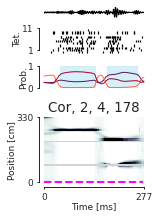

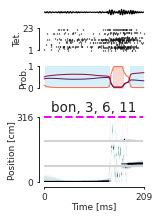

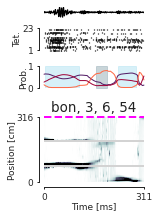

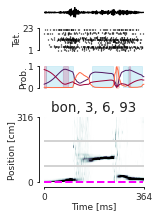

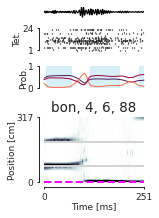

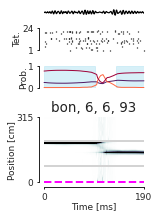

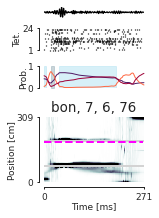

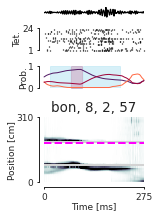

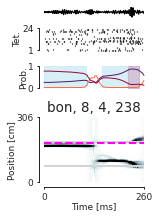

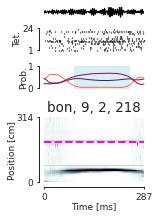

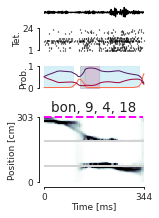

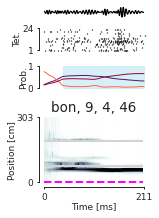

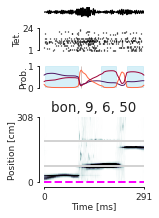

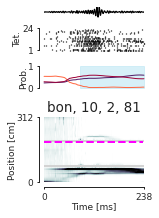

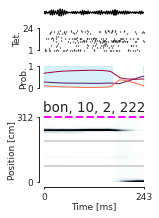

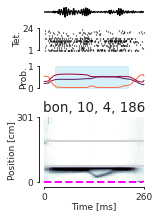

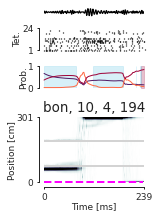

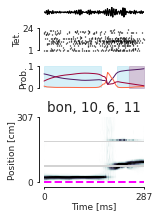

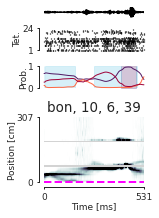

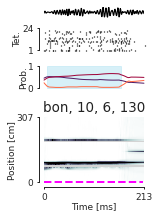

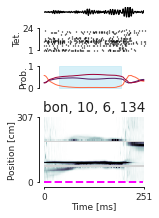

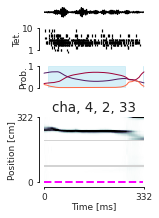

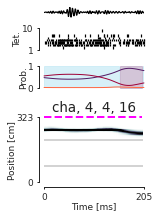

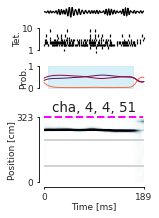

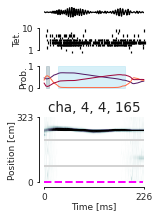

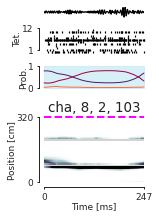

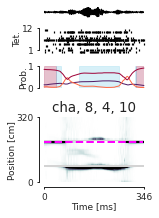

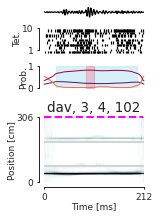

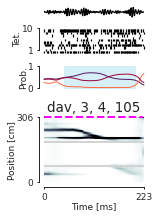

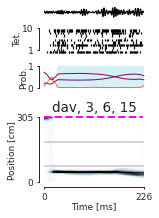

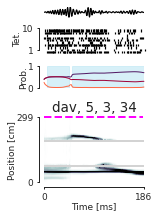

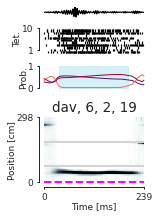

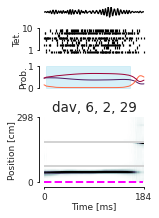

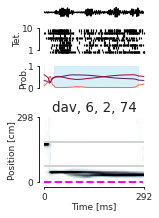

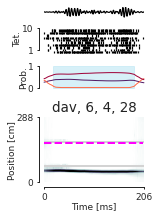

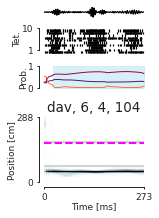

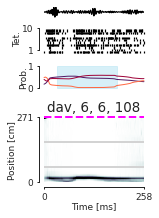

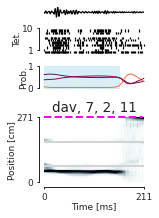

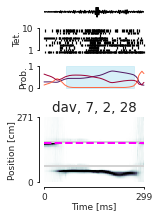

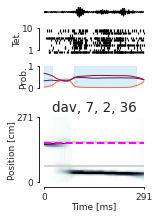

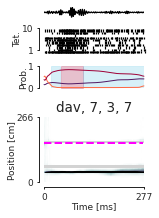

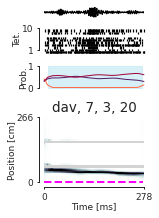

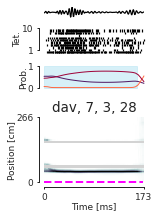

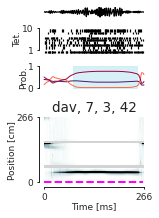

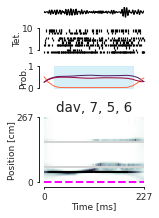

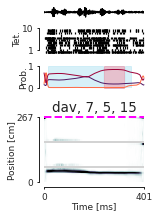

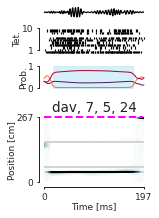

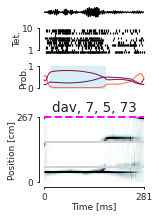

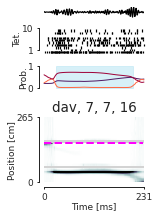

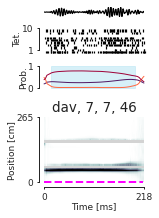

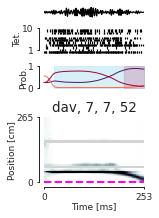

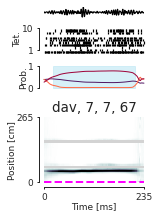

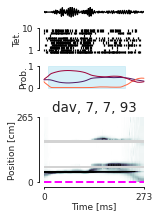

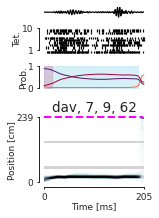

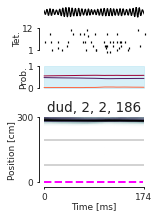

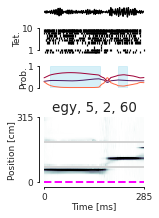

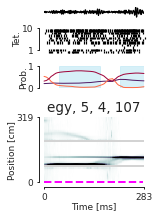

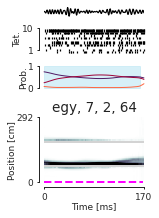

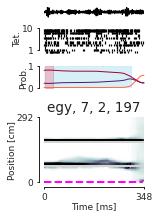

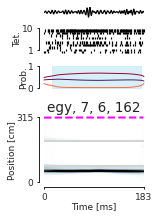

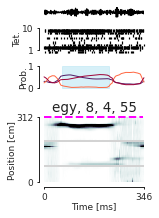

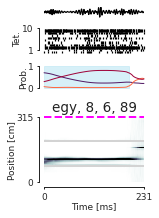

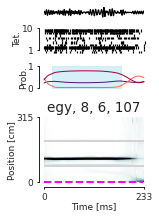

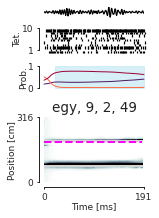

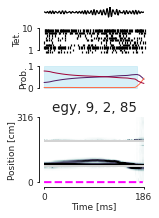

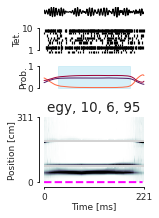

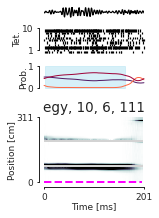

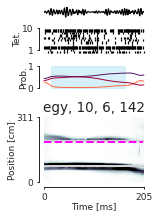

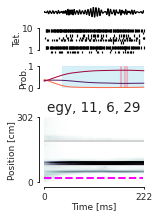

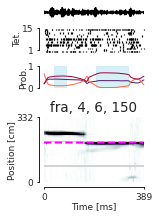

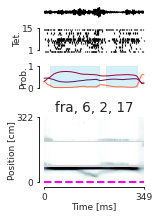

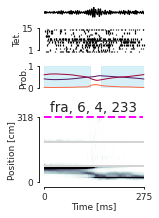

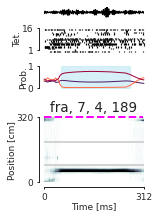

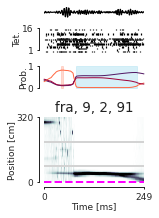

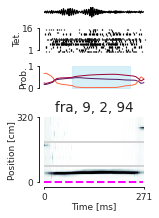

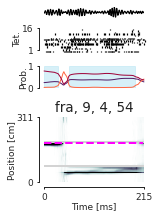

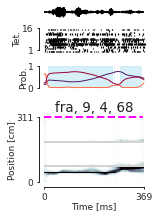

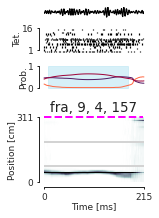

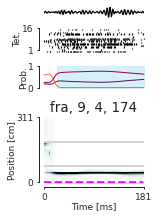

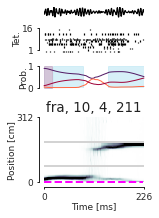

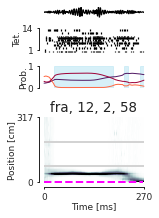

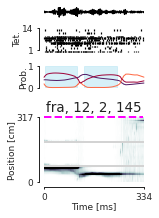

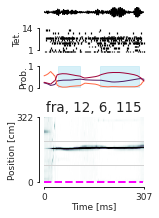

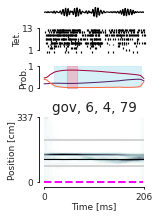

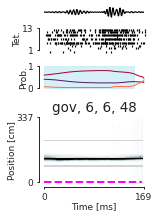

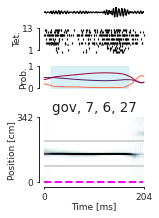

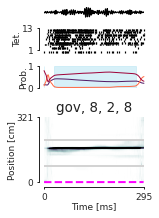

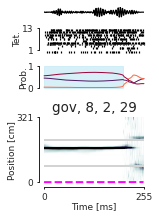

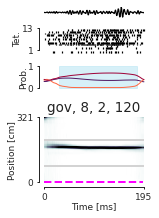

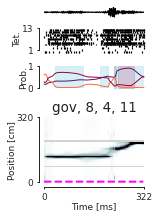

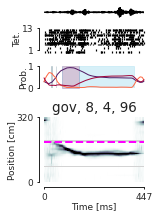

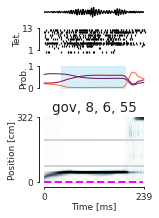

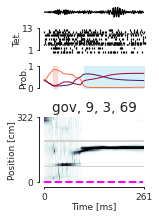

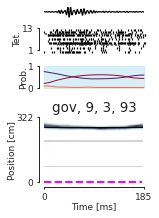

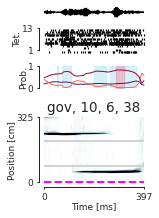

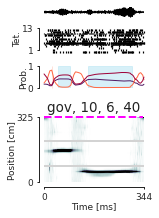

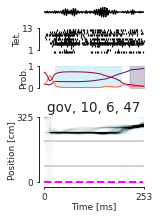

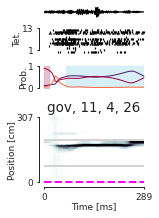

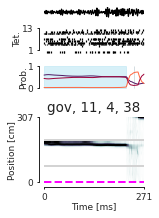

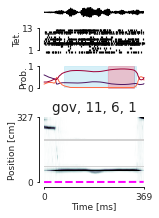

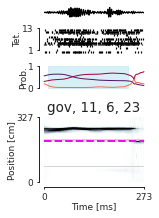

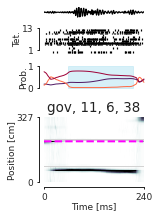

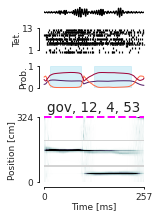

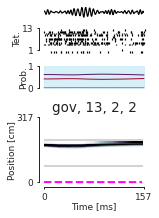

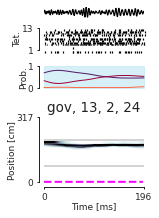

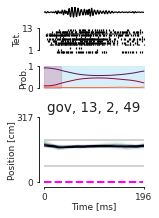

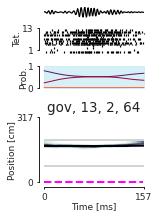

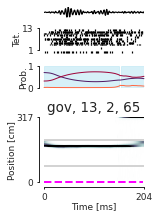

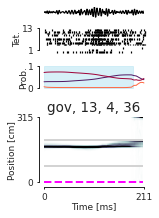

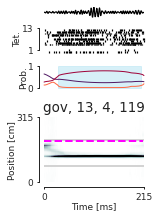

In [8]:
for epoch_key, df in non_local_hcm.groupby(["Animal ID", "day", "epoch"]):
    print(epoch_key)
    plot_ripple_figure_1D(
        epoch_key,
        df.reset_index().ripple_number.values,
        is_save_figure=False,
        cmap="bone_r",
        make_movie=False,
    )

In [9]:
client.close()